In [83]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
from matplotlib_venn import venn3, venn2
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
import viz
from style import *
import analyze_helper
import train
from sklearn import decomposition
from sklearn.calibration import calibration_curve

outcome_def = 'y_consec_thresh'
out_dir = 'results/jan16_4'
results = analyze_helper.load_results(out_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# compare all models
**baseline stats**

In [84]:
viz.print_metadata(acc=results.accuracy.max())

valid:		1862 aux+ / 7594 (0.245)
no_hotspots:	1662 aux+ / 7394 (0.225)
----------------------------------------
aux_early:	  59 aux+ / 1048 (0.056)
aux_late:	 504 aux+ /  874 (0.577)
aux_valid:	1099 aux+ / 5472 (0.201)
----------------------------------------
lifetime<=25:	3635 aux+ / 3941 (0.922)
lifetime>=243:	   1 aux- /    1 (1.000)
remaining:	 792 aux+ / 1530 (0.518)
----------------------------------------
predicted acc:			  0.716
total acc:			  0.865


**look at prediction metrics**

In [ ]:
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values(by=['accuracy', 'balanced_accuracy'], ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r.style.background_gradient(cmap='viridis', axis=0) # columns differently colored
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])

**look at feat importances**

In [35]:
r = results
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])
r = r[r.accuracy > 0.65]
keys = [k for k in r if '_f' in k]
keys_remapped = {k: k.replace('_f', '') for k in keys}
r = r[keys].rename(columns=keys_remapped)
# r = r.sort_values('lifetime')
# r = r[r.index.str.contains('39')]
r = r[~r.index.str.contains('=11')]
r = r[~r.index.str.contains('=7')]
r = r[~r.index.str.contains('=15')]
r = r.rename(columns={'mean_square_displacement': 'msd', 'total_displacement': 'td'})

# r = r[r.index.str.contains('11')]
# r = r[r2.index.str.contains('ros')]
# r = r[r.index.str.contains('none')]
r = r[[k for k in r if not 'std' in k]]


def rank(r):
    '''Rank feature importances appropriately
    '''
    r = r.abs()
    r = r.rank(axis=1, ascending=False, method='min')
    return r
# 
r = rank(r)
r = r.reindex(r.mean().sort_values(ascending=True).index, axis=1) # sort cols by mean rank

idxs = r.index
r.insert(0, 'acc', results.loc[idxs]['accuracy'])
r = r.sort_values('acc', ascending=False)

subset = list(r.keys())
subset.remove('acc')
r.fillna(0).style.background_gradient(cmap='viridis_r', axis=1, subset=subset) # rows differently colored

,acc,fall,X_min,sc_0,rise
model_type,,,,,
logistic_25_ros=1.2_select_rf=3,0.668,1,0,2,0
logistic_59_ros=1.2_select_rf=3,0.666,1,0,2,3
logistic_15_ros=1.2_select_rf=3,0.652,1,2,0,3


# analyze model predictions

In [85]:
df = data_tracks.get_data()
n = df.shape[0]

# normalize and store
X = df[data_tracks.get_feature_names(df)]
X_mean = X.mean()
X_std = X.std()
ks = list(X.keys())
norms = {ks[i]: {'mu': X_mean[i], 'std': X_std[i]} for i in range(len(ks))}
X = (X - X_mean) / X_std
y = df[outcome_def].values


# split testing data based on cell num
# cv_idx = data_tracks.cell_nums_train[0]
# idxs_test = df.cell_num.isin([cv_idx]) # this is the cv set for model's trained in the first cv fold
# X_test, Y_test = X[idxs_test], y[idxs_test]

# look at best models
r = results
r = r.sort_values('accuracy', ascending=False)
idx = np.array(r.index)
accs = np.array(r.accuracy)
print(idx[:10], accs[:10])

['rf_59_ros=1.2_select_rf=15' 'svm_25_ros=1.2_select_rf=11'
 'mlp2_25_ros=1_select_rf=11' 'svm_15_ros=1_select_lasso=15'
 'svm_15_ros=1_select_rf=15' 'svm_25_ros=1_select_lasso=15'
 'rf_59_ros=1_select_rf=15' 'svm_59_ros=1_select_lasso=15'
 'mlp2_25_ros=1.2_select_rf=5' 'mlp2_15_ros=1.2_select_rf=7'] [0.716 0.715 0.714 0.712 0.712 0.712 0.712 0.712 0.711 0.711]


### look at single model

In [86]:
model_name = idx[0]
d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df.cell_num, X, y)
y_full_cv = df[outcome_def].iloc[idxs_cv].values
preds = d_full_cv[model_name].values
preds_proba = d_full_cv[model_name + '_proba'].values

results_individual = pkl.load(open(oj(out_dir, f'{model_name}.pkl'), 'rb'))
assert np.mean(preds==y_full_cv) == np.average(results_individual['cv']['accuracy'], weights=results_individual['num_pts_by_fold_cv']), 'did not properly load model/data'

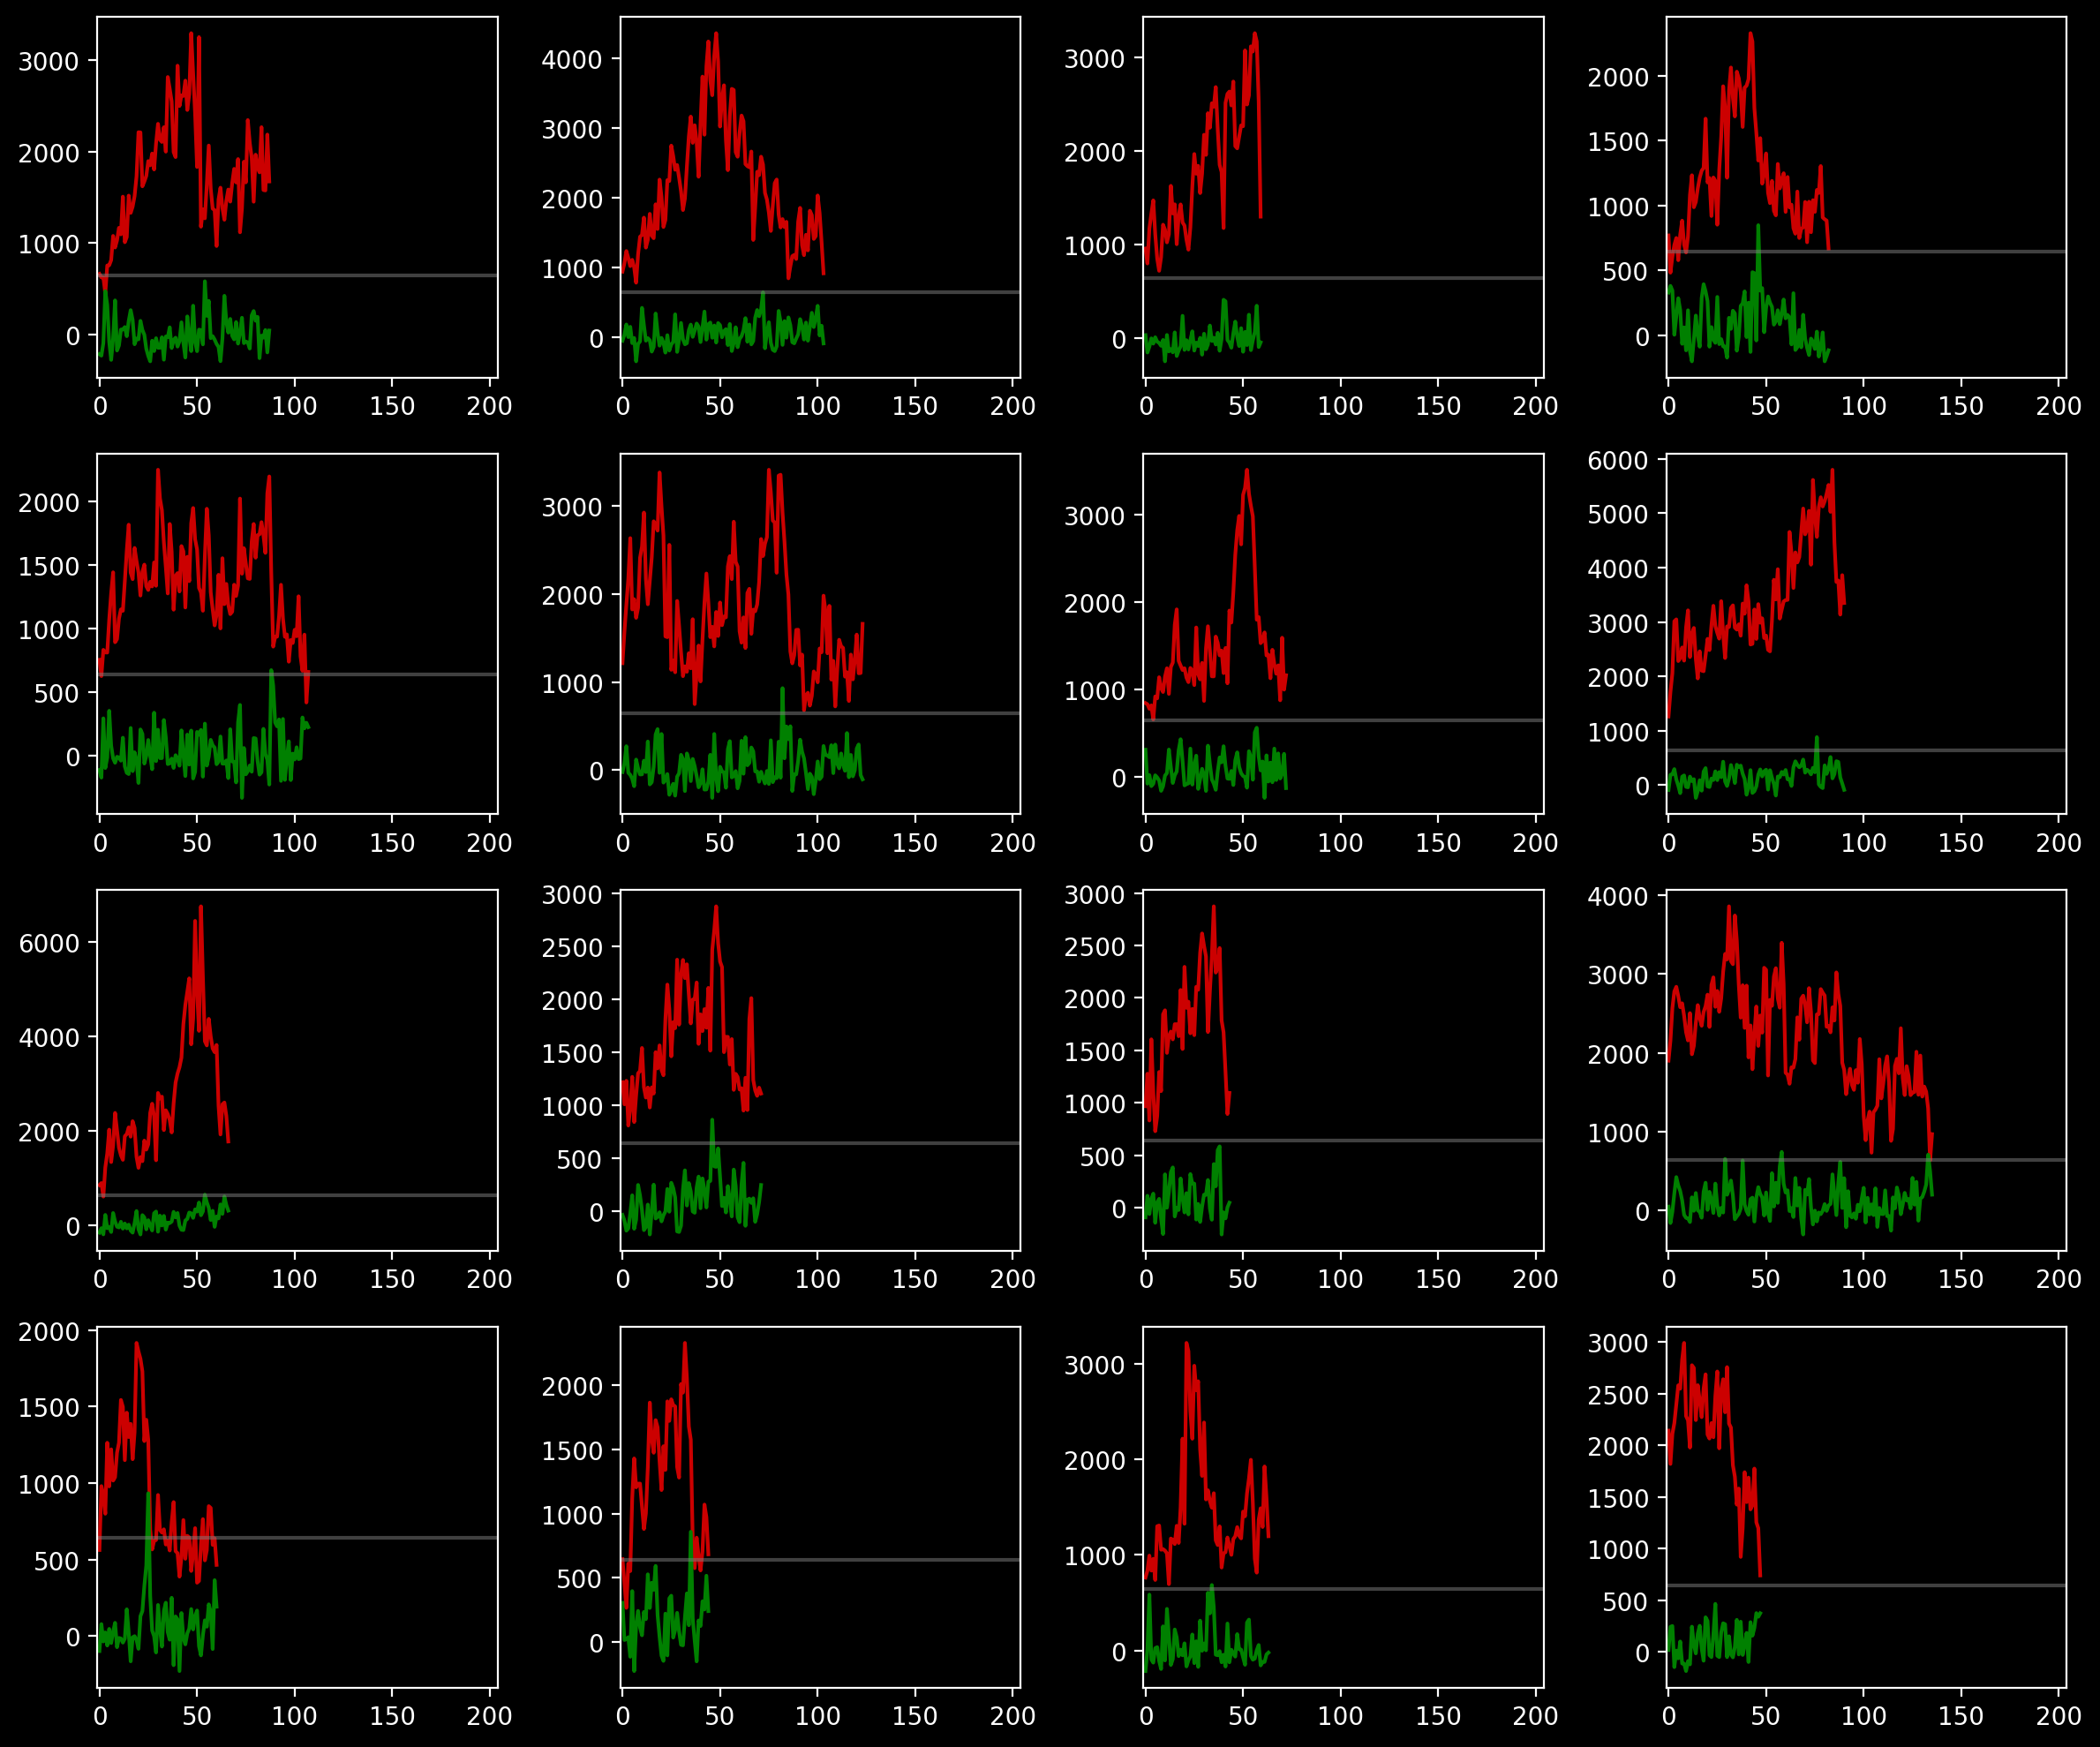

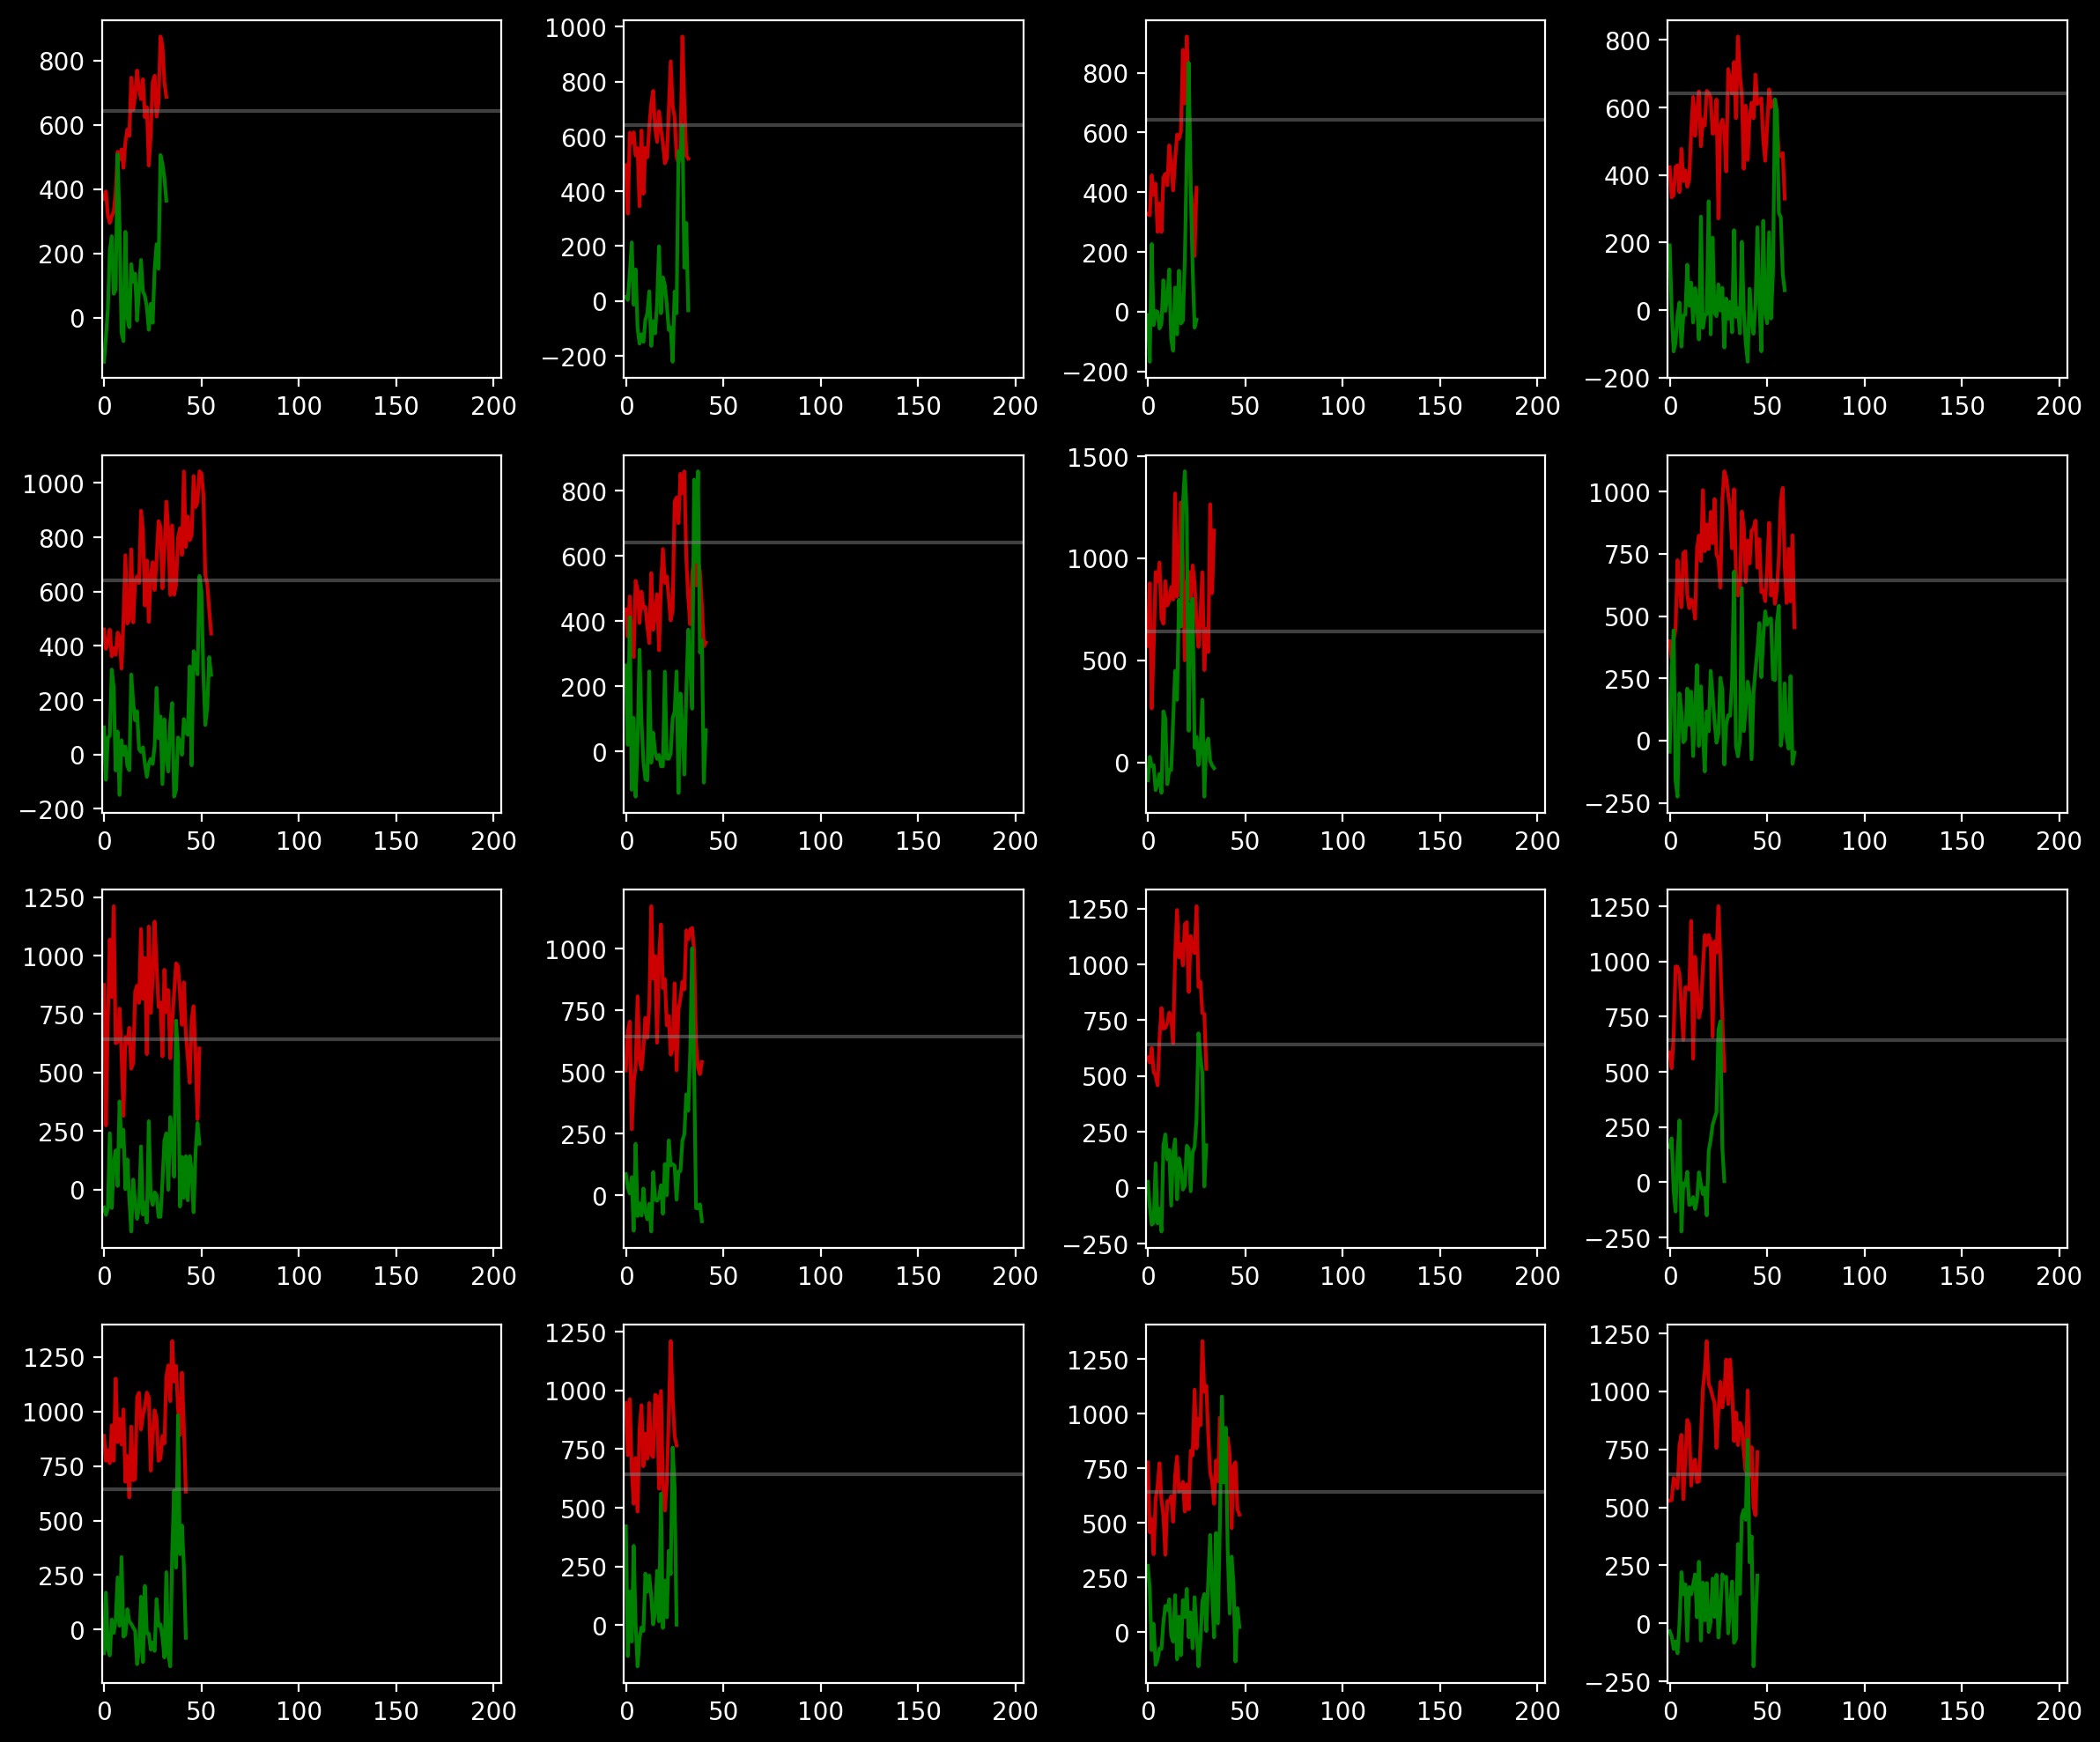

In [87]:
idxs_fp = preds > y_full_cv
idxs_fn = preds < y_full_cv
viz.viz_biggest_errs(df, df['X'].iloc[idxs_cv][idxs_fp], df['Y'].iloc[idxs_cv][idxs_fp], y_full_cv[idxs_fp], preds[idxs_fp], preds_proba[idxs_fp])    
viz.viz_biggest_errs(df, df['X'].iloc[idxs_cv][idxs_fn], df['Y'].iloc[idxs_cv][idxs_fn], y_full_cv[idxs_fn], preds[idxs_fn], preds_proba[idxs_fn])    

(array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,  28,  29,
        31,  32,  33,  34,  35,  36,  37,  40,  41,  42,  44,  45,  46,
        48,  49,  53,  55,  58,  60,  65,  66,  67,  72,  73,  75,  77,
        83,  91,  96, 103, 124, 135]), array([ 7,  4,  8,  5,  7,  7,  7,  3,  4,  7,  7,  6,  8,  6,  3,  6, 12,
        2,  2,  6,  4,  4,  5,  4,  6,  2,  2,  1,  2,  1,  3,  3,  1,  3,
        3,  1,  1,  3,  2,  1,  2,  2,  1,  2,  1,  1,  2,  1,  1,  2,  1,
        1,  1,  1,  1,  1,  1,  1]))


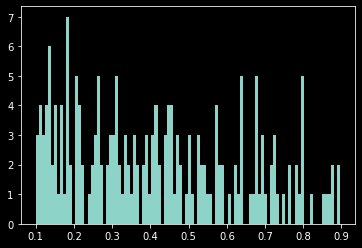

In [97]:
dist_to_end = df.iloc[idxs_fp]['lifetime'] - df.iloc[idxs_fp]['Y_peak_idx'] - 1
frac_to_end = 1 - df.iloc[idxs_fp]['Y_peak_idx'] / df.iloc[idxs_fp]['lifetime']
print(np.unique(dist_to_end, return_counts=True))
plt.hist(frac_to_end, bins=100)
plt.show()

In [ ]:
key = 'lifetime' # lifetime, X_min, fall
viz.viz_errs_1d(X.iloc[idxs_cv], preds, preds_proba, y_full_cv, norms, key=key)

In [ ]:
key1 = 'fall' # fall, x_pos, pc1
key2 = 'X_min' # X_min, y_pos, pc2
viz.viz_errs_2d(df, idxs_cv, preds, y_full_cv, key1=key1, key2=key2)

In [ ]:
viz.viz_errs_outliers_venn(X.iloc[idxs_cv], preds, y_full_cv, num_feats_reduced=5)

In [ ]:
plt.figure(dpi=200)
prob_true, prob_pred = calibration_curve(y_full_cv, preds_proba, normalize=False, n_bins=10, strategy='quantile')
plt.plot(prob_true, prob_pred, '.')
plt.plot([0, 1], [0, 1], alpha=0.3, color='gray')
plt.xlabel('true prob')
plt.ylabel('predicted prob')
plt.show()

**look at pcs**

In [ ]:
# perform pca
pca = decomposition.PCA(whiten=True)
pca.fit(X.iloc[idxs_cv])
viz.plot_pcs(pca, X.iloc[idxs_cv])

In [ ]:
pca = decomposition.PCA(n_components=2, whiten=True)
X_reduced = pca.fit_transform(X.iloc[idxs_cv])
plt.figure(dpi=200)
ys_neg = y[idxs_cv] == 0
plt.plot(X_reduced[:, 0][ys_neg], X_reduced[:, 1][ys_neg], 'o', 
         color=cr, alpha=0.3, markeredgewidth=0, ms=2)
plt.plot(X_reduced[:, 0][~ys_neg], X_reduced[:, 1][~ys_neg], 'o', 
         color=cb, alpha=0.3, markeredgewidth=0, ms=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### look at many models

In [51]:
# model_names = ['mlp2_11_none', 'svm_35_none', 'logistic_4_none', 'rf_9_none']
# model_names = ['mlp2_11_none', 'mlp2_9_none', 'mlp2_4_none']
model_names = idx[:3]
d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_names, out_dir, df.cell_num, X, y)
y_full_cv = df[outcome_def].iloc[idxs_cv].values

**venn-diagram**

In [ ]:
sets = []
for model_name in model_names:
    args = np.argwhere(d_full_cv[model_name] != y_full_cv)
    sets.append(set(args.flatten().tolist()))
    
plt.figure(dpi=300)
plt.title('venn diagram of shared errors')
venn3(sets, model_names[:3])
plt.show()

**ensemble err**

In [52]:
# ensemble
d_full_cv_probs = d_full_cv[[k for k in d_full_cv.keys() if 'proba' in k]]
preds_soft = d_full_cv_probs.sum(axis=1) / d_full_cv_probs.shape[1]

for score_name in train.scorers.keys():
    print(score_name, train.scorers[score_name](y_full_cv, preds_soft > 0.5))
# metrics.accuracy_score(y_ensemble, preds_soft>0.5) 

balanced_accuracy 0.663737231956361
accuracy 0.6830568720379147
precision 0.7150837988826816
recall 0.7703109327983951
f1 0.7416706904876872
roc_auc 0.6637372319563611
precision_recall_curve (array([0.59063981, 0.7150838 , 1.        ]), array([1.        , 0.77031093, 0.        ]), array([False,  True]))
roc_curve (array([0.        , 0.44283647, 1.        ]), array([0.        , 0.77031093, 1.        ]), array([2, 1, 0]))
